In [146]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import scprep
import matplotlib.pyplot as plt
from itertools import product
from torch_geometric.utils import dense_to_sparse
import torch

from sklearn.metrics import precision_recall_curve

# 1. Loading the RNASeq data for Mouse

## 1.1. Read the file

In [2]:
rnaseq=scprep.io.load_csv('data/GSE109071_rpkm.txt',delimiter='\t').transpose()
rnaseq

,Adora1,Prim2,Bai3,Cflar,Gpr39,Obsl1,Syt14,Pld5,Lmx1a,Lactb2,...,ERCC_3.66210938:mix1_7.32421875:mix2.1,ERCC_3.66210938:mix1_7.32421875:mix2.2,ERCC_1.83105469:mix1_3.66210938:mix2,ERCC_0.91552734:mix1_1.83105469:mix2.1,ERCC_0.91552734:mix1_1.83105469:mix2.2,ERCC_0.45776367:mix1_0.91552734:mix2,ERCC_0.22888184:mix1_0.45776367:mix2.1,ERCC_0.22888184:mix1_0.45776367:mix2.2,ERCC_0.11444092:mix1_0.22888184:mix2,ERCC_0.05722046:mix1_0.11444092:mix2
EB_130,9.613574,58.817405,0.0,4.924209,0.0,0.000000,0.000000,0.0,0.0,31.663245,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
EB_132,0.000000,38.302642,0.0,5.001059,0.0,0.000000,0.000000,0.0,0.0,64.523462,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
EB_131,0.000000,57.633573,0.0,0.000000,0.0,10.907428,0.000000,0.0,0.0,12.388011,...,11.638625,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
EB_137,0.000000,6.493274,0.0,0.000000,0.0,21.792194,0.000000,0.0,0.0,25.838208,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
EB_133,0.000000,37.226994,0.0,6.537890,0.0,1.354559,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EB_994,0.000000,1.035441,0.0,2.910504,0.0,0.000000,0.000000,0.0,0.0,32.528321,...,0.000000,142.397791,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
EB_997,3.610834,61.711468,0.0,0.000000,0.0,2.415288,0.000000,0.0,0.0,57.236697,...,0.000000,12.762099,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
EB_988,0.000000,10.809079,0.0,0.000000,0.0,7.466116,2.718754,0.0,0.0,9.400432,...,7.029370,0.000000,22.605884,0.674139,0.0,0.00000,0.0,0.0,0.0,0.0
EB_996,0.000000,36.225301,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,10.769359,...,0.000000,0.000000,0.000000,0.000000,0.0,15.69867,0.0,0.0,0.0,0.0


## 1.2. Preprocess the data

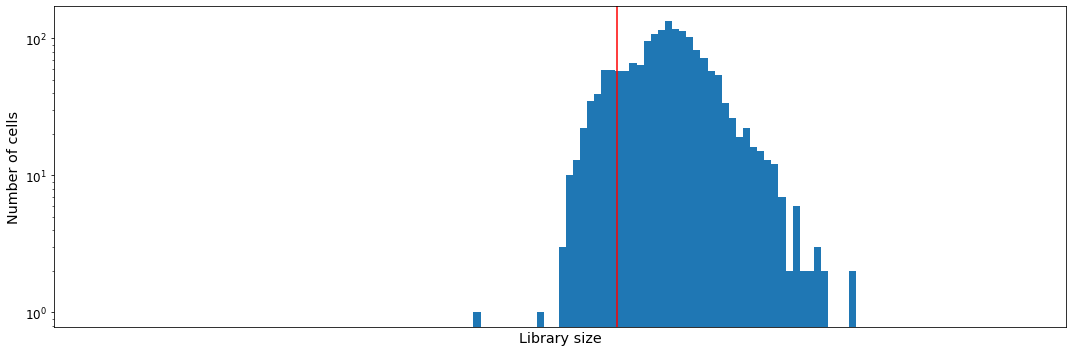

In [3]:
scprep.plot.plot_library_size(rnaseq,figsize=(15,5), cutoff=5.3*100000)
rnaseq = scprep.filter.filter_library_size(rnaseq, cutoff=5.3*100000)
rnaseq = scprep.filter.filter_rare_genes(rnaseq, min_cells=10)
rnaseq = scprep.transform.sqrt(scprep.normalize.library_size_normalize(rnaseq))

In [4]:
rnaseq

,Adora1,Prim2,Bai3,Cflar,Gpr39,Obsl1,Syt14,Pld5,Lmx1a,Lactb2,...,ERCC_14.6484375:mix1_29.296875:mix2.2,ERCC_7.32421875:mix1_14.6484375:mix2,ERCC_3.66210938:mix1_7.32421875:mix2.1,ERCC_3.66210938:mix1_7.32421875:mix2.2,ERCC_1.83105469:mix1_3.66210938:mix2,ERCC_0.91552734:mix1_1.83105469:mix2.1,ERCC_0.91552734:mix1_1.83105469:mix2.2,ERCC_0.22888184:mix1_0.45776367:mix2.2,ERCC_0.11444092:mix1_0.22888184:mix2,ERCC_0.05722046:mix1_0.11444092:mix2
EB_130,0.408333,1.010009,0.0,0.292240,0.0,0.000000,0.000000,0.0,0.0,0.741054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
EB_132,0.000000,0.820612,0.0,0.296520,0.0,0.000000,0.000000,0.0,0.0,1.065080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
EB_131,0.000000,1.003801,0.0,0.000000,0.0,0.436688,0.000000,0.0,0.0,0.465383,...,0.000000,0.000000,0.451087,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
EB_137,0.000000,0.337998,0.0,0.000000,0.0,0.619202,0.000000,0.0,0.0,0.674238,...,0.927348,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
EB_133,0.000000,0.808512,0.0,0.338826,0.0,0.154226,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EB_994,0.000000,0.122406,0.0,0.205222,0.0,0.000000,0.000000,0.0,0.0,0.686072,...,0.000000,0.000000,0.000000,1.435458,0.000000,0.000000,0.0,0.0,0.0,0.0
EB_997,0.242641,1.003099,0.0,0.000000,0.0,0.198447,0.000000,0.0,0.0,0.966047,...,0.000000,0.553017,0.000000,0.456165,0.000000,0.000000,0.0,0.0,0.0,0.0
EB_988,0.000000,0.416204,0.0,0.000000,0.0,0.345907,0.208736,0.0,0.0,0.388138,...,0.000000,0.765261,0.335637,0.000000,0.601897,0.103941,0.0,0.0,0.0,0.0
EB_996,0.000000,0.777635,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.423999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [5]:
links = pd.read_csv('BIOGRID-ORGANISM-Mus_musculus-4.0.189.tab3.txt', delimiter='\t')
BioGrid_PPI = links[links['Experimental System Type'] == 'physical']
BioGrid_PPI = BioGrid_PPI[['Official Symbol Interactor A','Official Symbol Interactor B']]
BioGrid_PPI['Official Symbol Interactor A'] = BioGrid_PPI['Official Symbol Interactor A'].str.lower()
BioGrid_PPI['Official Symbol Interactor B'] = BioGrid_PPI['Official Symbol Interactor B'].str.lower()
BioGrid_PPI = BioGrid_PPI.rename(
            columns={"Official Symbol Interactor A": "Gene_A", "Official Symbol Interactor B": "Gene_B"})
BioGrid_PPI

,Gene_A,Gene_B
0,smad2,rasd2
1,smad2,rab34
2,smad2,rhebl1
3,smad2,rab38
4,smad2,rhobtb1
...,...,...
80728,kif17,nxf2
80729,nxf2,kif17
80730,ccnf,vcp
80731,carm1,carm1


In [6]:
rna_seq = pd.DataFrame(rnaseq.transpose())
rna_seq.index = [x.lower() for x in rna_seq.index.to_list()]
rna_seq

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
adora1,0.408333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202411,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.371257,0.000000,0.242641,0.000000,0.000000,0.498299
prim2,1.010009,0.820612,1.003801,0.337998,0.808512,0.588713,1.037329,0.553764,0.080312,0.692692,...,0.0,0.0,0.0,0.568626,0.524237,0.122406,1.003099,0.416204,0.777635,0.835731
bai3,0.000000,0.000000,0.000000,0.000000,0.000000,0.116317,0.339877,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cflar,0.292240,0.296520,0.000000,0.000000,0.338826,0.000000,0.196888,0.129397,0.085795,0.315359,...,0.0,0.0,0.0,0.000000,0.072492,0.205222,0.000000,0.000000,0.000000,0.046474
gpr39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ercc_0.91552734:mix1_1.83105469:mix2.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.103941,0.000000,0.000000
ercc_0.91552734:mix1_1.83105469:mix2.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ercc_0.22888184:mix1_0.45776367:mix2.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ercc_0.11444092:mix1_0.22888184:mix2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
Filt_BioGrid_PPI = BioGrid_PPI.loc[BioGrid_PPI.Gene_A.isin(rna_seq.index.to_list()) & BioGrid_PPI.Gene_B.isin(
            rna_seq.index.to_list())]
Filt_BioGrid_PPI_Genes = np.union1d(Filt_BioGrid_PPI.Gene_A.unique(), Filt_BioGrid_PPI.Gene_B.unique())
filt_rna_seq = rna_seq[rna_seq.index.isin(Filt_BioGrid_PPI_Genes)]

In [8]:
filt_rna_seq

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
prim2,1.010009,0.820612,1.003801,0.337998,0.808512,0.588713,1.037329,0.553764,0.080312,0.692692,...,0.000000,0.000000,0.000000,0.568626,0.524237,0.122406,1.003099,0.416204,0.777635,0.835731
bai3,0.000000,0.000000,0.000000,0.000000,0.000000,0.116317,0.339877,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cflar,0.292240,0.296520,0.000000,0.000000,0.338826,0.000000,0.196888,0.129397,0.085795,0.315359,...,0.000000,0.000000,0.000000,0.000000,0.072492,0.205222,0.000000,0.000000,0.000000,0.046474
obsl1,0.000000,0.000000,0.436688,0.619202,0.154226,0.092909,0.000000,0.324064,0.704200,0.000000,...,0.000000,0.000000,0.000000,0.130520,0.000000,0.000000,0.198447,0.345907,0.000000,0.217634
lmx1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fam160b1,0.321523,0.000000,0.524857,0.310212,0.236482,0.374756,0.000000,0.293433,0.521209,0.336214,...,0.049779,0.462797,0.380393,0.400051,0.287537,0.261464,0.275093,0.383873,0.284499,0.147797
emx2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.116762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rab11fip2,0.000000,0.181066,0.000000,0.000000,0.202913,0.000000,0.000000,0.000000,0.302465,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
eif3a,1.484004,1.457293,1.517882,1.280572,1.495537,1.267672,1.534675,1.292357,1.442470,1.300484,...,1.231848,1.051237,1.184411,1.113868,1.007431,1.003354,0.658422,1.101260,1.385722,1.274552


In [9]:
Filt_BioGrid_PPI

,Gene_A,Gene_B
0,smad2,rasd2
1,smad2,rab34
2,smad2,rhebl1
3,smad2,rab38
4,smad2,rhobtb1
...,...,...
80728,kif17,nxf2
80729,nxf2,kif17
80730,ccnf,vcp
80731,carm1,carm1


In [ ]:
Adj = np.zeros([len(Filt_BioGrid_PPI_Genes), len(Filt_BioGrid_PPI_Genes)])
features = np.zeros([len(Filt_BioGrid_PPI_Genes), rna_seq.shape[1]])
for i in range(len(Filt_BioGrid_PPI)):
    row = np.where(Filt_BioGrid_PPI_Genes == Filt_BioGrid_PPI.iloc[i][0])[0][0]
    col = np.where(Filt_BioGrid_PPI_Genes == Filt_BioGrid_PPI.iloc[i][1])[0][0]
    Adj[row][col] = 1
    Adj[col][row] = 1

for i in range(len(Filt_BioGrid_PPI_Genes)):
    features[i] = rna_seq[rna_seq.index == Filt_BioGrid_PPI_Genes[i]]

In [ ]:
np.save('mouse_rnaSeq.npy',features)
np.save('MousePPI.npy',dense_to_sparse(torch.tensor(Adj))[0].numpy())

# Magic Imputation

In [11]:
import magic
magic_op = magic.MAGIC()

In [12]:
filt_rna_seq

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
prim2,1.010009,0.820612,1.003801,0.337998,0.808512,0.588713,1.037329,0.553764,0.080312,0.692692,...,0.000000,0.000000,0.000000,0.568626,0.524237,0.122406,1.003099,0.416204,0.777635,0.835731
bai3,0.000000,0.000000,0.000000,0.000000,0.000000,0.116317,0.339877,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cflar,0.292240,0.296520,0.000000,0.000000,0.338826,0.000000,0.196888,0.129397,0.085795,0.315359,...,0.000000,0.000000,0.000000,0.000000,0.072492,0.205222,0.000000,0.000000,0.000000,0.046474
obsl1,0.000000,0.000000,0.436688,0.619202,0.154226,0.092909,0.000000,0.324064,0.704200,0.000000,...,0.000000,0.000000,0.000000,0.130520,0.000000,0.000000,0.198447,0.345907,0.000000,0.217634
lmx1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fam160b1,0.321523,0.000000,0.524857,0.310212,0.236482,0.374756,0.000000,0.293433,0.521209,0.336214,...,0.049779,0.462797,0.380393,0.400051,0.287537,0.261464,0.275093,0.383873,0.284499,0.147797
emx2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.116762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rab11fip2,0.000000,0.181066,0.000000,0.000000,0.202913,0.000000,0.000000,0.000000,0.302465,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
eif3a,1.484004,1.457293,1.517882,1.280572,1.495537,1.267672,1.534675,1.292357,1.442470,1.300484,...,1.231848,1.051237,1.184411,1.113868,1.007431,1.003354,0.658422,1.101260,1.385722,1.274552


In [13]:
filt_rna_seq_magic = magic_op.fit_transform(filt_rna_seq.transpose())

Calculating MAGIC...
  Running MAGIC on 1468 cells and 9951 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.59 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.22 seconds.
    Calculating affinities...
    Calculated affinities in 0.23 seconds.
  Calculated graph and diffusion operator in 1.06 seconds.
  Running MAGIC with `solver='exact'` on 9951-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...


/home/ramin/anaconda3/envs/PytorchGeo/lib/python3.7/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))


  Calculated imputation in 0.37 seconds.
Calculated MAGIC in 1.50 seconds.


/home/ramin/anaconda3/envs/PytorchGeo/lib/python3.7/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [14]:
filt_rna_seq_magic = filt_rna_seq_magic.T
filt_rna_seq_magic

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
prim2,0.744787,0.745836,0.759283,0.709048,0.661849,0.724687,0.729581,0.696988,0.617260,0.707155,...,0.334167,0.427162,0.348481,0.427271,0.547846,0.336785,0.675520,0.549286,0.745234,0.585193
bai3,0.022867,0.022427,0.023505,0.021914,0.012923,0.023284,0.024627,0.017840,0.014459,0.021089,...,0.000000,0.000004,0.000000,0.000007,0.000057,0.000000,0.000000,0.000067,0.000000,0.000152
cflar,0.120454,0.123264,0.121325,0.109588,0.109777,0.103958,0.117875,0.122939,0.107536,0.111196,...,0.152457,0.111149,0.150507,0.119872,0.090594,0.156575,0.151407,0.090014,0.113108,0.092377
obsl1,0.237705,0.248083,0.262118,0.249939,0.217770,0.228114,0.244949,0.230628,0.218326,0.233368,...,0.098355,0.140869,0.104558,0.144763,0.201242,0.100536,0.565116,0.202389,0.212954,0.216803
lmx1a,0.000298,0.000316,0.000391,0.000543,0.000515,0.000392,0.000249,0.000276,0.000696,0.000406,...,0.001667,0.005861,0.002394,0.006590,0.012720,0.001806,0.000002,0.012931,0.000000,0.014288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fam160b1,0.234822,0.236535,0.238554,0.241874,0.211070,0.220719,0.228834,0.211891,0.219888,0.228827,...,0.289391,0.276531,0.293603,0.277115,0.247399,0.293751,0.234733,0.247141,0.132995,0.241238
emx2,0.001216,0.001637,0.002075,0.001360,0.000477,0.000897,0.001452,0.001970,0.000305,0.001089,...,0.006399,0.003149,0.006188,0.003549,0.000597,0.006488,0.064294,0.000612,0.001259,0.000650
rab11fip2,0.018757,0.023278,0.019807,0.022224,0.037115,0.020011,0.020329,0.022953,0.040039,0.022913,...,0.000058,0.000427,0.000099,0.000513,0.001284,0.000057,0.016272,0.001418,0.003721,0.002474
eif3a,1.453274,1.453473,1.458444,1.442262,1.419080,1.449718,1.444370,1.359913,1.419185,1.440142,...,1.270833,1.236496,1.270005,1.254021,1.263927,1.271819,1.111113,1.264300,1.334316,1.285314


In [15]:
ExpGraphImputed = np.load('ExpGraphConvMousePPI_imputed.npy')
ExpGraphImputed = pd.DataFrame(ExpGraphImputed,index=filt_rna_seq.index, columns=filt_rna_seq.columns)

In [16]:
MLPImputed = np.load('MLPMousePPI_imputed.npy').T
MLPImputed = pd.DataFrame(MLPImputed,index=filt_rna_seq.index, columns=filt_rna_seq.columns)

In [17]:
# filt_rna_seq_magic_pca = magic_op.transform(genes='pca_only')

In [18]:
# filt_rna_seq_pca = PCA(n_components=3).fit_transform(np.array(filt_rna_seq.transpose()))
# ExpGraphImputed_pca = PCA(n_components=3).fit_transform(np.array(ExpGraphImputed.transpose()))
# MLP_pca = PCA(n_components=3).fit_transform(np.array(MLPImputed.transpose()))

In [19]:
MLPImputed

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
prim2,2.142164,2.152333,2.083911,2.238497,2.076791,2.046293,2.129718,2.282909,2.050479,2.198191,...,1.888428,2.025851,2.121903,2.153414,1.910906,1.951766,1.977460,1.907422,1.942012,1.870403
bai3,1.019625,0.927972,0.958067,1.007643,0.966452,1.036637,1.038404,1.048576,1.000160,1.063704,...,0.855828,1.074687,0.925242,0.990611,0.976302,0.937465,0.777809,0.977291,1.302045,1.061149
cflar,1.444480,1.524333,1.546628,1.502823,1.511584,1.546995,1.517486,1.527496,1.432962,1.584846,...,1.045339,1.238945,0.976591,1.179143,1.220881,0.898923,1.090228,1.337294,1.326313,1.402503
obsl1,0.540150,0.511957,0.463917,0.552558,0.597084,0.543795,0.513067,0.577847,0.624668,0.490044,...,0.547806,0.543574,0.609001,0.570762,0.570834,0.565228,0.252915,0.591892,0.528564,0.565278
lmx1a,0.818177,0.873139,0.951920,0.961711,0.899987,0.911729,0.954643,1.078510,0.807102,0.996815,...,0.944264,1.065548,1.076513,1.069093,0.900081,1.042538,1.420635,0.857786,1.431465,0.943991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fam160b1,0.624062,0.634282,0.628142,0.685090,0.640479,0.616445,0.569479,0.522284,0.669505,0.624732,...,0.538208,0.577906,0.409750,0.615260,0.711802,0.463658,0.565974,0.774953,0.744668,0.803737
emx2,1.350057,1.518115,1.605574,1.404176,1.309861,1.372729,1.397861,1.365362,1.276342,1.416672,...,0.812905,1.065230,0.798632,1.097311,1.259214,0.878718,1.862741,1.182911,1.418278,1.398953
rab11fip2,1.053729,1.173832,1.289593,1.125150,0.860633,0.954715,1.085693,1.003743,0.838868,1.090639,...,0.693756,0.701731,0.791640,0.729007,0.733700,0.855236,1.307078,0.695194,2.077721,0.662397
eif3a,0.190856,0.291655,0.173150,0.254959,0.260591,0.193942,0.212916,0.169384,0.270419,0.176525,...,0.140411,0.099086,0.156400,0.136838,0.141960,0.319788,0.238202,0.136178,0.141855,0.046481


In [20]:
# fig, (ax1, ax2) = plt.subplots(2,2, figsize=(16, 12))

# scprep.plot.scatter2d(filt_rna_seq_pca, c=filt_rna_seq.T['prim2'], 
#                       label_prefix="PC", title='PCA without MAGIC',
#                       legend_title="Ifitm1", ax=ax1[0], ticks=False)

# scprep.plot.scatter2d(filt_rna_seq_magic_pca, c=filt_rna_seq_magic['prim2'], 
#                       label_prefix="PC", title='PCA with MAGIC',
#                       legend_title="Ifitm1", ax=ax1[1], ticks=False)

# scprep.plot.scatter2d(MLP_pca, c=MLPImputed.T['prim2'], 
#                       label_prefix="PC", title='PCA with MLP',
#                       legend_title="Ifitm1", ax=ax2[0], ticks=False)

# scprep.plot.scatter2d(ExpGraphImputed_pca, c=ExpGraphImputed.T['prim2'], 
#                       label_prefix="PC", title='PCA with ExpGraphConv',
#                       legend_title="Ifitm1", ax=ax2[1], ticks=False)

# plt.tight_layout()
# plt.show()

In [21]:
valTF = pd.read_csv('Mouse_EScells_perturbation_targets.txt',delimiter='\t')
valTF = valTF[['sourceName','targetName']]
valTF['sourceName'] = valTF.sourceName.str.lower()
valTF['targetName'] = valTF.targetName.str.lower()
valTF = valTF.drop_duplicates(ignore_index=True)
valTF

/home/ramin/anaconda3/envs/PytorchGeo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sourceName,targetName
0,nanog,actn3
1,nanog,plin2
2,nanog,aldoc
3,nanog,anp32a
4,nanog,anxa3
...,...,...
104196,sox17,dhrs7
104197,sox17,gstp2
104198,sox17,ndufs4
104199,sox17,ppfibp2


In [22]:
filt_rna_seq=filt_rna_seq[filt_rna_seq.index.isin(valTF['sourceName'].to_list())|filt_rna_seq.index.isin(valTF['targetName'].to_list())].drop_duplicates()

In [23]:
src_filt_rna_seq = filt_rna_seq[filt_rna_seq.index.isin(valTF['sourceName'].to_list())]
trg_filt_rna_seq = filt_rna_seq[filt_rna_seq.index.isin(valTF['targetName'].to_list())]

In [24]:
ExpGraphConv_src_filt_rna_seq = ExpGraphImputed[ExpGraphImputed.index.isin(valTF['sourceName'].to_list())]
ExpGraphConv_trg_filt_rna_seq = ExpGraphImputed[ExpGraphImputed.index.isin(valTF['targetName'].to_list())]

In [25]:
MLP_src_filt_rna_seq = MLPImputed[MLPImputed.index.isin(valTF['sourceName'].to_list())]
MLP_trg_filt_rna_seq = MLPImputed[MLPImputed.index.isin(valTF['targetName'].to_list())]

In [26]:
Magic_src_filt_rna_seq = filt_rna_seq_magic[filt_rna_seq_magic.index.isin(valTF['sourceName'].to_list())]
Magic_trg_filt_rna_seq = filt_rna_seq_magic[filt_rna_seq_magic.index.isin(valTF['targetName'].to_list())]

In [27]:
trg_filt_rna_seq

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
prim2,1.010009,0.820612,1.003801,0.337998,0.808512,0.588713,1.037329,0.553764,0.080312,0.692692,...,0.000000,0.000000,0.000000,0.568626,0.524237,0.122406,1.003099,0.416204,0.777635,0.835731
bai3,0.000000,0.000000,0.000000,0.000000,0.000000,0.116317,0.339877,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cflar,0.292240,0.296520,0.000000,0.000000,0.338826,0.000000,0.196888,0.129397,0.085795,0.315359,...,0.000000,0.000000,0.000000,0.000000,0.072492,0.205222,0.000000,0.000000,0.000000,0.046474
obsl1,0.000000,0.000000,0.436688,0.619202,0.154226,0.092909,0.000000,0.324064,0.704200,0.000000,...,0.000000,0.000000,0.000000,0.130520,0.000000,0.000000,0.198447,0.345907,0.000000,0.217634
lmx1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fam160b1,0.321523,0.000000,0.524857,0.310212,0.236482,0.374756,0.000000,0.293433,0.521209,0.336214,...,0.049779,0.462797,0.380393,0.400051,0.287537,0.261464,0.275093,0.383873,0.284499,0.147797
emx2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.116762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rab11fip2,0.000000,0.181066,0.000000,0.000000,0.202913,0.000000,0.000000,0.000000,0.302465,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
eif3a,1.484004,1.457293,1.517882,1.280572,1.495537,1.267672,1.534675,1.292357,1.442470,1.300484,...,1.231848,1.051237,1.184411,1.113868,1.007431,1.003354,0.658422,1.101260,1.385722,1.274552


In [28]:
Magic_src_filt_rna_seq

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
sox17,0.007866,0.006870,0.007367,0.008268,0.014088,0.013182,0.010825,0.056175,0.010659,0.010861,...,8.896844e-02,0.079990,0.087811,0.086040,0.090668,0.088872,0.803222,0.093624,0.093343,0.120086
prdm14,0.000087,0.000165,0.001594,0.000147,0.000072,0.000028,0.000234,0.002124,0.000000,0.000122,...,0.000000e+00,0.000000,0.000000,0.000000,0.000012,0.000000,0.013482,0.000013,0.000000,0.000036
zfp281,0.533270,0.530239,0.532889,0.553155,0.585173,0.546661,0.536116,0.549054,0.580999,0.547121,...,5.948245e-01,0.610164,0.596488,0.617435,0.658798,0.595061,0.313433,0.657968,0.317964,0.664274
nr5a2,0.007635,0.008165,0.006622,0.008354,0.007472,0.008464,0.007688,0.006858,0.007073,0.008162,...,1.613174e-02,0.012548,0.011220,0.012911,0.019262,0.011528,0.000025,0.019704,0.006976,0.020809
gata3,0.078481,0.063948,0.069077,0.050662,0.023942,0.057794,0.064860,0.055716,0.026789,0.055827,...,1.433721e-01,0.161259,0.151746,0.165854,0.192964,0.147015,0.106331,0.196414,1.276192,0.207570
rxra,0.096900,0.094332,0.102498,0.107160,0.092404,0.098561,0.101333,0.114845,0.105038,0.097015,...,2.849261e-01,0.228772,0.271990,0.231742,0.178912,0.275115,0.060860,0.180004,0.118378,0.175453
id1,1.335424,1.274531,1.344720,0.954561,0.539513,1.081972,1.226366,0.910699,0.474282,1.007123,...,3.129766e+00,2.730743,3.083784,2.792279,2.448865,3.102864,2.056208,2.443594,0.761563,2.383039
mybl2,0.418964,0.409619,0.408472,0.398557,0.424826,0.415254,0.414011,0.378419,0.397476,0.413062,...,7.415064e-01,0.778172,0.739241,0.770953,0.810145,0.741846,0.415355,0.803774,1.084971,0.793356
sall4,1.648715,1.658842,1.660123,1.639469,1.614466,1.638713,1.623814,1.520843,1.624228,1.626619,...,1.445039e+00,1.348252,1.433902,1.362350,1.267156,1.435084,1.102948,1.267915,1.019535,1.263520
sox2,0.436314,0.418873,0.397605,0.463052,0.545571,0.440081,0.434321,0.442955,0.549641,0.467515,...,6.436002e-01,0.472952,0.626575,0.506981,0.372305,0.641868,0.030111,0.372710,0.035829,0.368106


In [29]:
ExpGraphConv_trg_filt_rna_seq

,EB_130,EB_132,EB_131,EB_137,EB_133,EB_134,EB_139,EB_140,EB_136,EB_141,...,EB_987,EB_990,EB_993,EB_992,EB_989,EB_994,EB_997,EB_988,EB_996,EB_995
prim2,2.014032,2.323068,1.963895,2.016985,1.965405,1.986878,2.008286,2.244953,1.793029,2.213645,...,1.740585,2.064528,2.068738,2.223458,2.210120,1.797499,1.933581,1.997006,2.046744,1.992667
bai3,0.988641,1.103413,0.946411,1.075465,1.166244,1.285186,0.963607,1.008977,1.270147,1.053359,...,0.887439,0.884084,0.871264,1.072332,0.897098,0.770085,0.808457,0.910171,1.439775,1.025810
cflar,1.599548,1.510252,1.462653,1.520589,1.547888,1.591142,1.431482,1.568334,1.534233,1.619271,...,1.050046,1.235506,0.955815,1.180014,1.350578,0.838927,1.045007,1.364089,1.329026,1.353410
obsl1,0.479725,0.592455,0.254482,0.613328,0.541377,0.375658,0.387048,0.483763,0.703845,0.375973,...,0.645133,0.421594,0.692856,0.660435,0.807261,0.772399,0.256553,0.673656,0.530759,0.770271
lmx1a,0.695569,1.038167,0.926536,0.860608,0.996467,0.945390,1.009254,1.035091,0.924529,1.024365,...,0.876845,0.925763,1.177332,1.055606,0.567158,1.017239,1.637902,0.770375,1.197044,0.839502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fam160b1,0.683704,0.691138,0.523797,0.814036,0.769589,0.636024,0.604889,0.555714,0.652197,0.612457,...,0.430873,0.581067,0.299848,0.611208,0.728623,0.423158,0.625418,0.746744,0.741933,0.739194
emx2,1.518382,1.567579,1.590260,1.378292,1.404053,1.257967,1.521861,1.260399,1.415110,1.542202,...,0.934756,0.913167,0.882678,1.138747,1.361279,1.111448,1.939179,1.237719,1.431686,1.371595
rab11fip2,0.885807,1.144246,1.379069,0.947451,0.939207,1.003388,1.121321,1.092612,0.739258,0.974314,...,0.454703,0.904370,1.119321,0.868838,0.863436,0.771599,1.245169,0.668321,2.001849,0.562180
eif3a,0.216077,0.258467,0.137718,0.225601,0.171045,0.144101,0.149087,0.164482,0.140374,0.132108,...,0.063066,0.122160,0.132704,0.084480,0.082687,0.176854,0.198880,0.059643,0.153899,0.078536


In [30]:
import findr
l = findr.lib(path='/usr/local/lib',loglv=12)

In [31]:
res = l.pij_rank(src_filt_rna_seq.to_numpy(dtype=np.float32), trg_filt_rna_seq.to_numpy(dtype=np.float32))

In [32]:
res_ExpGraphConv = l.pij_rank(ExpGraphConv_src_filt_rna_seq.to_numpy(), ExpGraphConv_trg_filt_rna_seq.to_numpy())

In [33]:
res_MLP = l.pij_rank(MLP_src_filt_rna_seq.to_numpy(), MLP_trg_filt_rna_seq.to_numpy())

In [34]:
res_magic = l.pij_rank(Magic_src_filt_rna_seq.to_numpy(dtype=np.float32), Magic_trg_filt_rna_seq.to_numpy(dtype=np.float32))

In [36]:
res_magic

{'ret': 0,
 'p': array([[0.99964404, 0.99976486, 0.57304835, ..., 0.99942154, 0.9997847 ,
         0.9993403 ],
        [0.80978936, 0.99919575, 0.95928025, ..., 0.9989305 , 0.99822134,
         0.9993716 ],
        [0.99957275, 0.99978495, 0.99884206, ..., 0.99933904, 0.9998479 ,
         0.9989903 ],
        ...,
        [0.9999275 , 0.99905545, 0.78824514, ..., 0.9999022 , 0.7158929 ,
         0.999792  ],
        [0.9993405 , 0.9970889 , 0.34915853, ..., 0.52158594, 0.9994524 ,
         0.99958605],
        [0.9994562 , 0.26706642, 0.99894935, ..., 0.9994503 , 0.9994938 ,
         0.99964035]], dtype=float32)}

In [37]:
validation_data = pd.DataFrame([[i,j] for i,j in product(src_filt_rna_seq.index.to_list(),trg_filt_rna_seq.index.to_list())])
# validation_data[0] = validation_data[0].str.cat(validation_data[1],sep=",")
# validation_data

In [38]:
validation_data = validation_data.drop_duplicates()
validation_data

,0,1
0,sox17,prim2
1,sox17,bai3
2,sox17,cflar
3,sox17,obsl1
4,sox17,lmx1a
...,...,...
304865,tcf7l2,fam160b1
304866,tcf7l2,emx2
304867,tcf7l2,rab11fip2
304868,tcf7l2,eif3a


In [39]:
validation_data = validation_data.merge(valTF[['sourceName','targetName']], left_on=[0,1], right_on=['sourceName','targetName'], how='left').fillna(0)

In [40]:
validation_data['sourceName'].loc[validation_data['sourceName']!=0] = 1

In [41]:
validation_data = validation_data.iloc[:,:3]
validation_data.columns = ['Source',"Target","GT"]
validation_data['GT'].unique()

array([0, 1], dtype=object)

In [117]:
validation_data

,Source,Target,GT
0,sox17,prim2,0
1,sox17,bai3,0
2,sox17,cflar,0
3,sox17,obsl1,0
4,sox17,lmx1a,0
...,...,...,...
304865,tcf7l2,fam160b1,0
304866,tcf7l2,emx2,0
304867,tcf7l2,rab11fip2,0
304868,tcf7l2,eif3a,0


In [44]:
prediction_p = pd.concat([validation_data.iloc[:,:2],pd.DataFrame(res['p'].flatten(),columns=['prob'])],1)
prediction_p['prob_not'] = 1-prediction_p['prob']
prediction_p[['prob_not','prob']]

,prob_not,prob
0,0.001359,0.998641
1,0.001107,0.998893
2,0.879293,0.120707
3,0.000436,0.999564
4,0.000969,0.999031
...,...,...
304865,0.485250,0.514750
304866,0.810418,0.189582
304867,0.301262,0.698738
304868,0.001192,0.998808


In [46]:
ExpGraphConv_prediction_p = pd.concat([validation_data.iloc[:,:2],pd.DataFrame(res_ExpGraphConv['p'].flatten(),columns=['prob'])],1)
ExpGraphConv_prediction_p['prob_not'] = 1-ExpGraphConv_prediction_p['prob']
ExpGraphConv_prediction_p[['prob_not','prob']]

,prob_not,prob
0,0.001040,0.998960
1,0.000921,0.999079
2,0.001021,0.998979
3,0.000438,0.999562
4,0.000728,0.999272
...,...,...
304865,0.005913,0.994087
304866,0.000614,0.999386
304867,0.000751,0.999249
304868,0.481688,0.518312


In [47]:
MLP_prediction_p = pd.concat([validation_data.iloc[:,:2],pd.DataFrame(res_MLP['p'].flatten(),columns=['prob'])],1)
MLP_prediction_p['prob_not'] = 1-MLP_prediction_p['prob']
MLP_prediction_p[['prob_not','prob']]

,prob_not,prob
0,0.000691,0.999309
1,0.000617,0.999383
2,0.001144,0.998856
3,0.000302,0.999698
4,0.000826,0.999174
...,...,...
304865,0.305041,0.694959
304866,0.000247,0.999753
304867,0.000737,0.999263
304868,0.016997,0.983003


In [48]:
Magic_prediction_p = pd.concat([validation_data.iloc[:,:2],pd.DataFrame(res_magic['p'].flatten(),columns=['prob'])],1)
Magic_prediction_p['prob_not'] = 1-Magic_prediction_p['prob']
Magic_prediction_p[['prob_not','prob']]

,prob_not,prob
0,0.000356,0.999644
1,0.000235,0.999765
2,0.426952,0.573048
3,0.000221,0.999779
4,0.000498,0.999502
...,...,...
304865,0.466028,0.533972
304866,0.000524,0.999476
304867,0.000550,0.999450
304868,0.000506,0.999494


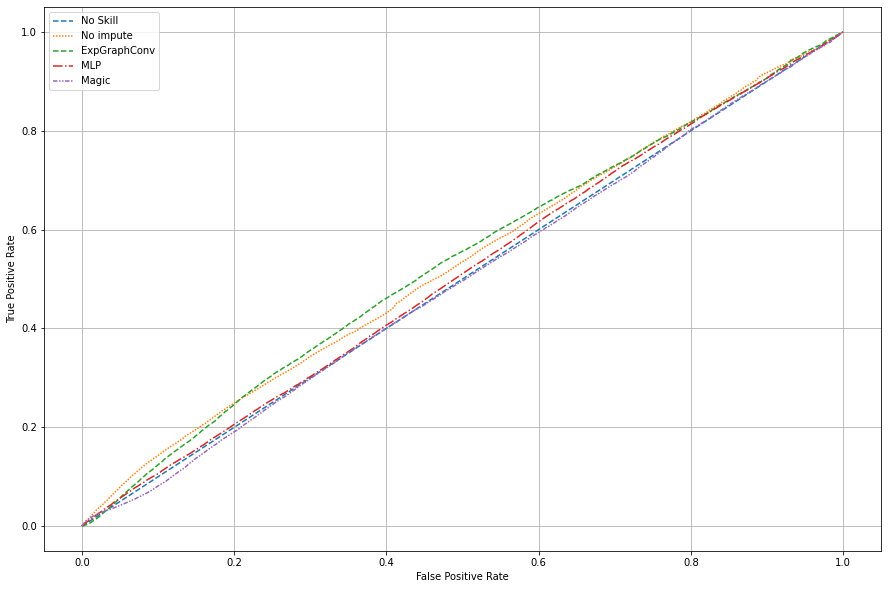

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
plt.figure(figsize=(15,10))
testy = validation_data['GT'].to_numpy(dtype=np.int64)
ns_probs = [0 for _ in range(len(testy))]

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
fpr, tpr, _ = roc_curve(validation_data['GT'].to_numpy(dtype=np.int64), prediction_p[['prob']].to_numpy())
ExpGraphConvfpr, ExpGraphConvtpr, _ = roc_curve(validation_data['GT'].to_numpy(dtype=np.int64), ExpGraphConv_prediction_p[['prob']].to_numpy())
MLPfpr, MLPtpr, _ = roc_curve(validation_data['GT'].to_numpy(dtype=np.int64), MLP_prediction_p[['prob']].to_numpy())
Magicfpr, Magicptr, _ = roc_curve(validation_data['GT'].to_numpy(dtype=np.int64), Magic_prediction_p[['prob']].to_numpy())

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, linestyle=(0, (1, 1)), label='No impute')
plt.plot(ExpGraphConvfpr, ExpGraphConvtpr, linestyle='dashed', label='ExpGraphConv')
plt.plot(MLPfpr, MLPtpr, linestyle='dashdot', label='MLP')
plt.plot(Magicfpr, Magicptr, linestyle=(0, (3, 1, 1, 1, 1, 1)), label='Magic')


#skplt.metrics.plot_precision_recall_curve(validation_data['GT'].to_numpy(dtype=np.int64), MLP_prediction_p[['prob','prob_not']].to_numpy(),figsize=(15,10))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.grid()
# show the plot
plt.show()

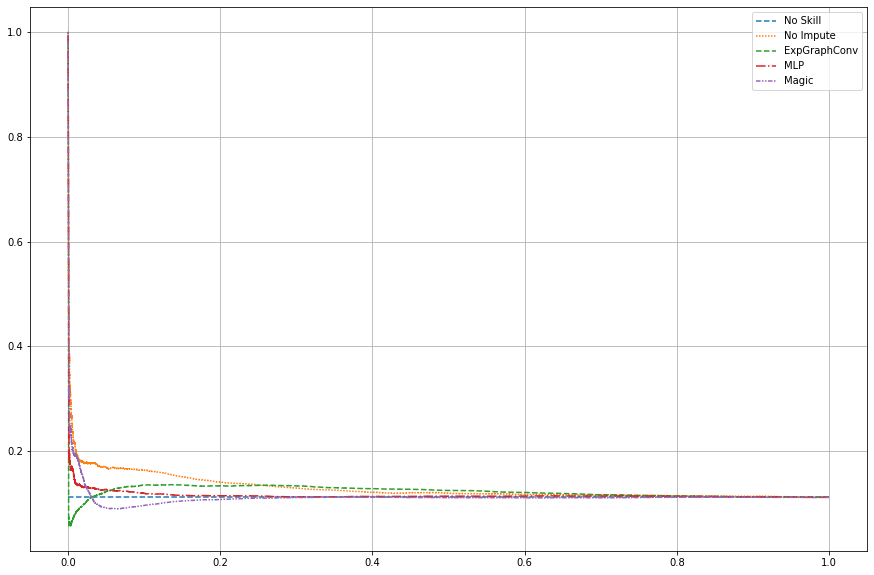

In [55]:
plt.figure(figsize=(15,10))

testy = validation_data['GT'].to_numpy(dtype=np.int64)
no_skill = len(testy[testy==1]) / len(testy)

precision, recall, _ = precision_recall_curve(validation_data['GT'].to_numpy(dtype=np.int64), prediction_p[['prob']].to_numpy())
ExpGraphConv_precision, ExpGraphConv_recall, _ = precision_recall_curve(validation_data['GT'].to_numpy(dtype=np.int64), ExpGraphConv_prediction_p[['prob']].to_numpy())
MLP_precision, MLP_recall, _ = precision_recall_curve(validation_data['GT'].to_numpy(dtype=np.int64), MLP_prediction_p[['prob']].to_numpy())
Magic_precision, Magic_recall, _ = precision_recall_curve(validation_data['GT'].to_numpy(dtype=np.int64), Magic_prediction_p[['prob']].to_numpy())



#f1, auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)




plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, linestyle=(0, (1, 1)), label='No Impute')
plt.plot(ExpGraphConv_recall, ExpGraphConv_precision, linestyle='dashed', label='ExpGraphConv')
plt.plot(MLP_recall, MLP_precision, linestyle='dashdot', label='MLP')
plt.plot(Magic_recall, Magic_precision, linestyle=(0, (3, 1, 1, 1, 1, 1)), label='Magic')




# show the legend
plt.legend()
plt.grid()
# show the plot
plt.show()

In [58]:
print('Not imputed:',auc(recall, precision))
print('ExpGraphConv:',auc(ExpGraphConv_recall, ExpGraphConv_precision))
print('MLP:',auc(MLP_recall, MLP_precision))
print('Magic:',auc(Magic_recall, Magic_precision))

Not imputed: 0.12954894767445013
ExpGraphConv: 0.12308894283735414
MLP: 0.11605997486638123
Magic: 0.11179534959791734


In [113]:
prediction_p

,Source,Target,prob,prob_not
0,sox17,prim2,0.998641,0.001359
1,sox17,bai3,0.998893,0.001107
2,sox17,cflar,0.120707,0.879293
3,sox17,obsl1,0.999564,0.000436
4,sox17,lmx1a,0.999031,0.000969
...,...,...,...,...
304865,tcf7l2,fam160b1,0.514750,0.485250
304866,tcf7l2,emx2,0.189582,0.810418
304867,tcf7l2,rab11fip2,0.698738,0.301262
304868,tcf7l2,eif3a,0.998808,0.001192


In [129]:
val_prediction_p = prediction_p.merge(valTF[['sourceName','targetName']]
                   , left_on=['Source', 'Target']
                   , right_on=['sourceName','targetName']).loc[:,prediction_p.columns]
val_prediction_p

,Source,Target,prob,prob_not
0,sox17,rps6kc1,0.910316,0.089684
1,sox17,ptpn18,0.998864,0.001136
2,sox17,lamc1,0.999506,0.000494
3,sox17,tsga10,0.620274,0.379726
4,sox17,fzd7,0.998950,0.001050
...,...,...,...,...
34140,tcf7l2,ifit1,0.594698,0.405302
34141,tcf7l2,lzts2,0.999072,0.000928
34142,tcf7l2,adra2a,0.189484,0.810516
34143,tcf7l2,habp2,0.999295,0.000705


In [130]:
val_ExpGraphConv_prediction_p = ExpGraphConv_prediction_p.merge(valTF[['sourceName','targetName']]
                   , left_on=['Source', 'Target']
                   , right_on=['sourceName','targetName']).loc[:,prediction_p.columns]
val_ExpGraphConv_prediction_p

,Source,Target,prob,prob_not
0,sox17,rps6kc1,0.999316,0.000684
1,sox17,ptpn18,0.468664,0.531336
2,sox17,lamc1,0.999627,0.000373
3,sox17,tsga10,0.994204,0.005796
4,sox17,fzd7,0.999287,0.000713
...,...,...,...,...
34140,tcf7l2,ifit1,0.999251,0.000749
34141,tcf7l2,lzts2,0.999243,0.000757
34142,tcf7l2,adra2a,0.999488,0.000512
34143,tcf7l2,habp2,0.355681,0.644319


In [131]:
sorted_no_impute = val_prediction_p.sort_values(by=['prob'], ascending=False)

In [132]:
sorted_ExpGraphConv = val_ExpGraphConv_prediction_p.loc[sorted_no_impute.index,['prob', 'prob_not']]

In [134]:
sorted_no_impute

,Source,Target,prob,prob_not
879,zfp281,zfp281,1.0,0.0
13169,nanog,nanog,1.0,0.0
33011,pou5f1,pou5f1,1.0,0.0
5338,sall4,sall4,1.0,0.0
6475,sox2,sox2,1.0,0.0
...,...,...,...,...
17243,nr0b1,cxcl10,0.0,1.0
13680,nanog,plk2,0.0,1.0
3979,gata3,ppp2r2b,0.0,1.0
33861,tcf7l2,ptprd,0.0,1.0


In [135]:
cat = pd.concat([sorted_no_impute, sorted_ExpGraphConv], axis=1)
cat.columns = sorted_no_impute.columns.to_list()+['prob_y', 'prob_not_y']
cat = cat.reset_index()
cat

,index,Source,Target,prob,prob_not,prob_y,prob_not_y
0,879,zfp281,zfp281,1.0,0.0,1.000000,0.000000
1,13169,nanog,nanog,1.0,0.0,1.000000,0.000000
2,33011,pou5f1,pou5f1,1.0,0.0,1.000000,0.000000
3,5338,sall4,sall4,1.0,0.0,1.000000,0.000000
4,6475,sox2,sox2,1.0,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...
34140,17243,nr0b1,cxcl10,0.0,1.0,0.979548,0.020452
34141,13680,nanog,plk2,0.0,1.0,0.999650,0.000350
34142,3979,gata3,ppp2r2b,0.0,1.0,0.479804,0.520196
34143,33861,tcf7l2,ptprd,0.0,1.0,0.700024,0.299976


In [137]:
cat[(cat.prob>0.9) & (cat.prob_y<0.1)]

,index,Source,Target,prob,prob_not,prob_y,prob_not_y
59,14037,myod1,pax3,0.999980,0.000020,0.000335,0.999665
67,14031,myod1,aox3,0.999976,0.000024,0.023239,0.976761
73,15188,myod1,gfra3,0.999973,0.000027,0.000019,0.999981
155,15081,myod1,hoxc4,0.999910,0.000090,0.000248,0.999752
162,14178,myod1,sox18,0.999906,0.000094,0.007875,0.992125
...,...,...,...,...,...,...,...
22229,32112,pou5f1,ddx3y,0.918534,0.081466,0.000057,0.999943
22263,1570,nr5a2,gabarapl1,0.916941,0.083059,0.000090,0.999910
22379,2827,gata3,pde2a,0.913776,0.086224,0.000000,1.000000
22412,6295,sox2,chmp4b,0.912918,0.087082,0.087753,0.912247


In [145]:
(filt_rna_seq.loc['myod1']!=0).sum()

26

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


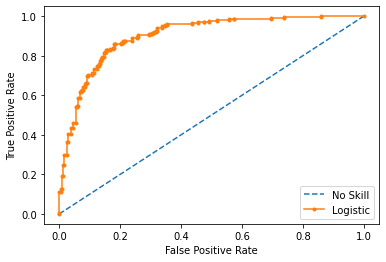

In [137]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.841 auc=0.898


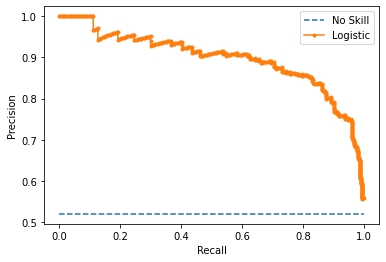

In [57]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()